In [76]:
import numpy as np
import pandas as pd
import pcreode
import math
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings( 'ignore')

In [193]:
def get_data( fact):
    # get curved trajectory 
    a = 25
    b = 20
    x0 = 12
    y0 = 0
    bot = np.arange(-math.pi, -math.pi/4.0, (math.pi - math.pi/4.0)/(500*fact)) + np.random.uniform( -0.006, 0.006, 500*fact)
    x_ep = x0 + a*np.cos( bot) + np.random.uniform( -2.0, 2.0, len(bot))
    y_ep = y0 + b*np.sin( bot) + np.random.uniform( -2.0, 2.0, len(bot))
    
    # get center linear trajectory
    n_end_points = 500
    x_l = np.random.uniform(-30.0, 15.0, n_end_points)
    y_l = np.random.uniform( -1.8,  1.8, n_end_points)
    
    # bot linear branch
    x_bot = np.random.uniform( 15, 40, n_end_points)
    y_bot = (-4/5.0)*x_bot + 12 + np.random.uniform( -2.0, 2.0, len(x_bot))

    # top linear branch
    x_top = np.random.uniform( 15, 40, n_end_points)
    y_top = (4/5.0)*x_top + -12 + np.random.uniform( -2.0, 2.0, len(x_top))
    
    # mid linear branch
    x_mid = np.random.uniform( 0, 12, n_end_points)
    y_mid = (7/5.0)*x_mid + 0 + np.random.uniform( -2.2, 2.2, len(x_mid))
    
    x = np.append( x_ep, [x_l, x_bot, x_top, x_mid])
    y = np.append( y_ep, [y_l, y_bot, y_top, y_mid])
    
    return( np.transpose( np.vstack( [x,y])))

In [194]:
data = get_data( 2)

((-40, 50), (-40, 50))

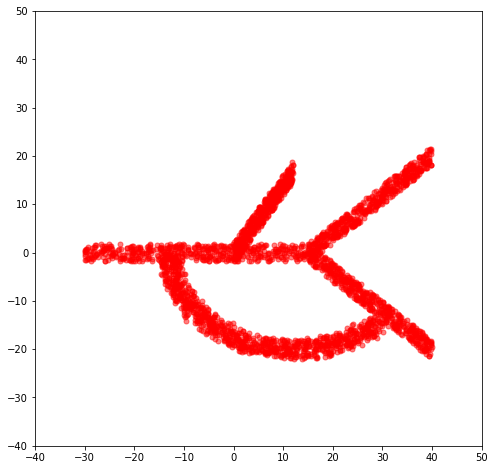

In [195]:
fig = plt.figure( figsize=(8,8))
ax1 = fig.add_subplot(111)
cc = 'r'
ax1.scatter( data[:,0], data[:,1], alpha=0.5, s=25, c=cc)
ax1.set_xlim(-40,50), ax1.set_ylim(-40,50)

best guess starting radius = 0.761162796578


0.7611627965782388

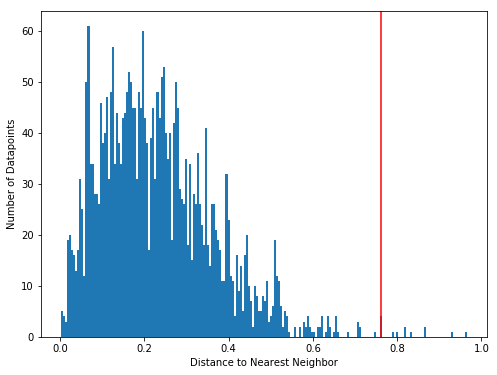

In [196]:
dens = pcreode.Density( data)
dens.nearest_neighbor_hist()

calculating densities for datapoints: 0 -> 2999
****Always check density overlay for radius fit****


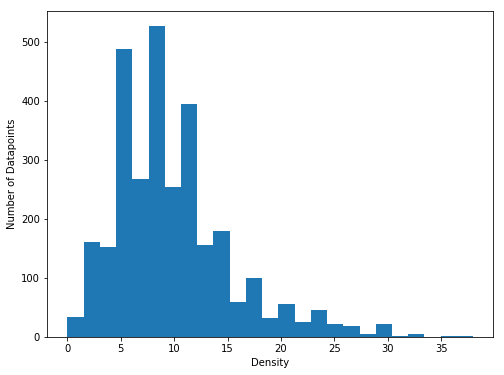

In [197]:
density = dens.get_density( radius=0.80)
dens.density_hist( n_bins=25)

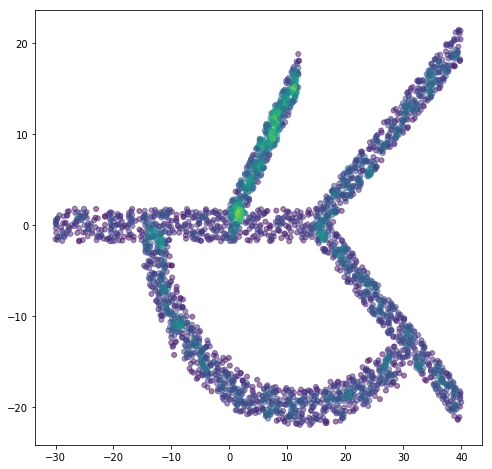

In [198]:
fig = plt.figure( figsize=(8,8))
ax1 = fig.add_subplot(111)
cc = density
ax1.scatter( data[:,0], data[:,1], alpha=0.5, s=25, c=cc)

In [237]:
noise  = 0.0
target = 25.0

In [238]:
downed, downed_ind = pcreode.Down_Sample( data, density, noise, target)

Number of data points in downsample = 2070


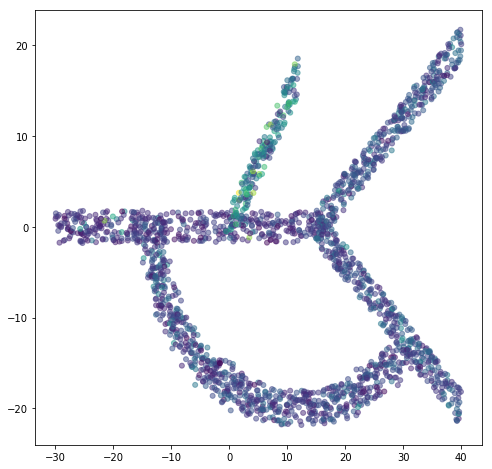

In [239]:
fig = plt.figure( figsize=(8,8))
ax1 = fig.add_subplot(111)
cc = density[downed_ind]
ax1.scatter( downed[:,0], downed[:,1], alpha=0.5, s=25, c=cc)

In [257]:
data = get_data( 2)
endstates_ind, down_ind, clust_ids, std_cls = pcreode.find_endstates( data, density, noise, target, potential_clusters=10, cls_thresh=-1.0)

Number of data points in downsample = 2074
Constructing density kNN
finding endstates
Number of endstates found -> 8


(-30, 30)

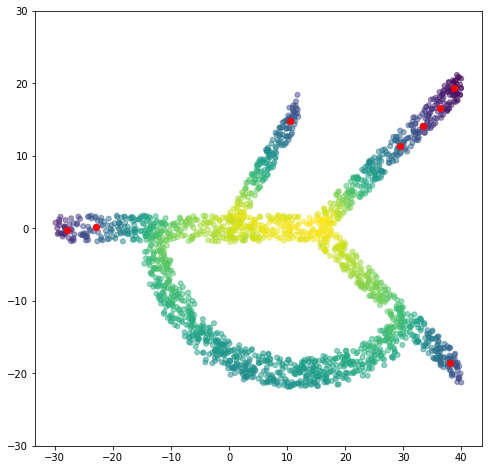

In [258]:
fig = plt.figure( figsize=(8,8))
ax1 = fig.add_subplot(111)
cc = std_cls
ax1.scatter( data[down_ind,0], data[down_ind,1], alpha=0.5, s=25, c=cc)
ax1.scatter( data[endstates_ind,0], data[endstates_ind,1], alpha=0.9, s=40, c='r')
ax1.set_ylim(-30,30)

In [259]:
file_path = "./test/"

In [262]:
out_graph, out_ids = pcreode.pCreode( data=data, density=density, noise=noise, target=target, file_path=file_path, num_runs=1, cls_thresh=-1.0)

Performing 1 independent runs, may take some time
Number of data points in downsample = 2074
Constructing density kNN
finding endstates
Number of endstates found -> 8
hierarchical placing
consensus aligning
saving files for run_num 1


(-30, 30)

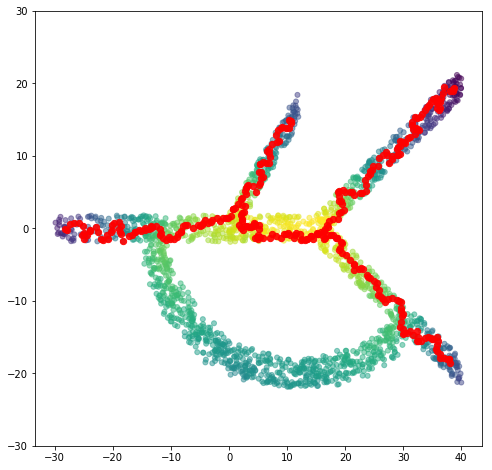

In [263]:
fig = plt.figure( figsize=(8,8))
ax1 = fig.add_subplot(111)
cc = std_cls
ax1.scatter( data[down_ind,0], data[down_ind,1], alpha=0.5, s=25, c=cc)
ax1.scatter( data[out_ids,0], data[out_ids,1], alpha=0.9, s=40, c='r')
ax1.set_ylim(-30,30)

(-30, 30)

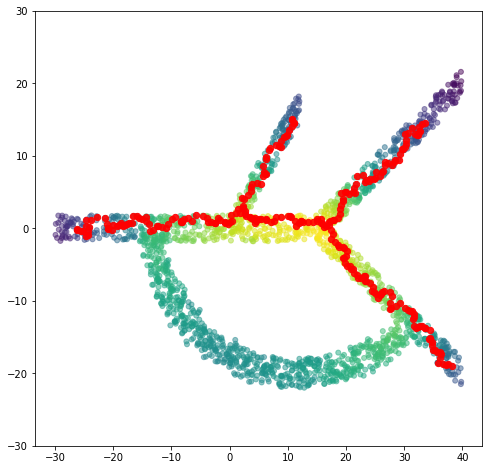

In [220]:
fig = plt.figure( figsize=(8,8))
ax1 = fig.add_subplot(111)
cc = std_cls
ax1.scatter( data[down_ind,0], data[down_ind,1], alpha=0.5, s=25, c=cc)
ax1.scatter( data[out_ids,0], data[out_ids,1], alpha=0.9, s=40, c='r')
ax1.set_ylim(-30,30)

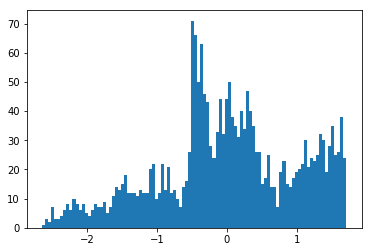

In [228]:
_ = plt.hist( std_cls, bins=100)

In [267]:
import igraph as _igraph
import matplotlib.pyplot as _plt
import random
from igraph import *
from sklearn.metrics import pairwise_distances
from sklearn.cluster import KMeans as _KMeans
from sklearn import preprocessing
from sklearn import metrics
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import minimum_spanning_tree
import os as _os

In [279]:
def pCreode( data, density, noise, target, file_path, num_runs=100, potential_clusters=10, cls_thresh=0.0, start_id=0, mute=False):
    ''' 
    Function for running full pCreode algorithm, with the addition of principle component extremes found to be under the closeness threshold added as endstates
    :param data:    numpy ndarray of data set
    :param density: numpy array of calculated densities for each datapoint
    :param noise:   value for noise threshold, densities below value will be removed during downsampling
    :param target:  value for target density
    :param file_path: path to directory where output files will be stored
    :param num_runs:  number of independent runs to perform, default is 100 
    :param potential_clusters: value for upper range of number of clusters to search for, default value is 10
    :param cls_thresh: value for closeness threshold use to separate potential endstates from transitional cell types default value is 0.0
    :param start_id: integer at which to start labeling output graphs, allows for addition of graphs to previously ran lot
    :param  mute: boolean operator to suppress print statements
    :return: will save creode files in given directory
    '''
    if not ( isinstance( data, np.ndarray)):
        raise TypeError( 'data variable must be numpy ndarray')
    if not ( isinstance( density, np.ndarray)):
        raise TypeError( 'data variable must be numpy array')
    if not ( _os.path.exists( file_path)):
        raise TypeError( 'please supply a valid directory')
        
    # Save sys.stdout to return print output if muted 
    old_stdout = sys.stdout
    # Mute print statements if True
    if( mute==True):
        sys.stdout = open( os.devnull, 'w')
        
    print( "Performing {0} independent runs, may take some time".format( num_runs))
  
    for run_itr in range( num_runs):
        
        # get downsampled dataset
        down, down_ind = pcreode.Down_Sample( data, density, noise, target)

        # array for orginal density (prior to downsampling) of downsampled data points
        down_density = density[down_ind]
        n_down       = len( down)

        # get distance matrix for down sampled dataset
        Dist = np.array( pairwise_distances( down, down, n_jobs=1))

        # set upper and lower thresholds for number of neighbors to connect in density 
        # based nearest neighbor graph (d-kNN) (current fixed values are 2 and 10)
        upper_nn = 10
        lower_nn = 2

        # assign number of neighbors to connect to, to each datapoint 
        sorted_nn = np.linspace( lower_nn, upper_nn, n_down, dtype=int)
        nn = np.zeros( n_down, dtype=int)
        nn[np.argsort( down_density)] = sorted_nn

        # create adjacency matrix to hold neighbor connections for d-kNN
        knn_adj = np.zeros( ( n_down, n_down), dtype=int)
        for zz in range( n_down):
            knn_adj[zz,np.argsort( Dist[zz,:])[1:nn[zz]]] = 1
        # to make symetric add adj with transpose
        knn_adj = np.add( knn_adj, knn_adj.T)
        
        # make sure there is only one component by constructing a MST
        Dist_csr = csr_matrix( np.triu(Dist))
        Tcsr     = minimum_spanning_tree( Dist_csr)
        mst_adj  = pd.DataFrame( Tcsr.todense()).values
        mst_adj  = np.add( mst_adj, mst_adj.T)
        
        # add the two adjacency matrices
        adj = np.add( knn_adj, mst_adj)
        
        # make sure overlaping neighbors arnt double counted
        adj[adj>0] = 1.0

        # normalize the orginal densities of the downsampled data points
        norm = preprocessing.MinMaxScaler()
        dens_norm = np.ravel( norm.fit_transform( down_density.reshape( -1, 1).astype( np.float)))

        # weight edges of d-kNN by inverse of orginal densities
        den_adj = np.zeros( ( n_down, n_down), dtype=float)
        print( "Constructing density kNN")
        # get coordinates of connections from adjacency matrix
        adj_coords = np.nonzero( np.triu( adj))
        for hh, uu in zip( adj_coords[0], adj_coords[1]):
            # take the minimum density of nodes connected by the edge
            # add 0.1 so that no connection is lost (not equal to zero)
            den_adj[hh,uu] = 1.1 - ( min( [dens_norm[hh], dens_norm[uu]]))
        # make symetric 
        den_adj  = np.add( den_adj, den_adj.T)
        # final edge weights are product of density weights and distance matrix
        dist_weighted_adj = np.multiply( Dist, adj)
        dens_weighted_adj = np.multiply( Dist, den_adj)
        # create undirected igraph instance using weighted matrix
        d_knn = _igraph.Graph.Weighted_Adjacency( dist_weighted_adj.tolist(), loops=False, mode=ADJ_UNDIRECTED)

        print( "finding endstates")
        # get closeness of graph and standardize to aid in endstate identification
        cls     = np.array( d_knn.closeness( weights="weight"))
        scaler  = preprocessing.StandardScaler()
        std_cls = scaler.fit_transform( cls.reshape(-1,1)).ravel()

        # using closeness as threshold (default value = 0.0) get potential endstates
        low_cls = down[std_cls<=cls_thresh]
        # array to hold silhouette score for each cluster try
        sil_score = [0]*potential_clusters

        # prefrom K means clustering and score each attempt
        for ss in range( potential_clusters):
            kmeans_model  = _KMeans( n_clusters=ss+2, random_state=10).fit( low_cls)
            label         = kmeans_model.labels_
            sil_score[ss] = metrics.silhouette_score( low_cls, labels=label, metric='l2')

        # find most likely number of clusters from scores above and double to allow for rare cell types
        num_clusters = ( np.argmax( sil_score) + 2) * 2
        clust_model = _KMeans( n_clusters=num_clusters, random_state=10).fit( low_cls)
        label      = clust_model.labels_
        print( "Number of endstates found -> {0}".format( num_clusters))

        endstates = clust_model.cluster_centers_
        endstates_ind = np.zeros( (num_clusters, 1), dtype=int)
        for ii in range( num_clusters):
            endstates_ind[ii] = pcreode.find_closest_ind( endstates[ii], data)
        
        endstates_ind = endstates_ind.ravel()
        endstates = data[endstates_ind,:]
        num_clusters = len( endstates_ind)
        
        # Endstate data points were picked from full data set, so need to be appended to down and down_ind
        # Create array to hold where end_states are located within the downsampled dataset
        cen_ind = np.zeros( num_clusters, dtype=int)
        ind = n_down
        for es in range( num_clusters):
            # first need to check if they are already in the graph, if not:
            if( ~np.in1d( endstates_ind[es], down_ind)):
                down     = np.vstack( ( down, endstates[es]))
                down_ind = np.append( down_ind, endstates_ind[es])
                cen_ind[es] = ind
                ind = ind + 1
            # if data point is already in down
            else:
                cen_ind[es] = np.argwhere( endstates_ind[es]==down_ind).ravel()[0]
                continue
        
        # re-initialize using density and distance weighted edges         
        dens_knn = _igraph.Graph.Weighted_Adjacency( dens_weighted_adj.tolist(), loops=False, mode=ADJ_UNDIRECTED)

        # add endstate data points to the already constructed dens_knn graph, connecting to 2 closest neighbors
        # future update will so that number of edges is based on density of data point
        knn_num = 2
        # add nodes to graph that will represent endstates
        dens_knn.add_vertices( num_clusters)
        # get distance matrix to be used for finding closeset neighbors in graph
        end_dist = np.array( pairwise_distances( endstates, down[:-num_clusters], n_jobs=1))
        for kk in range( num_clusters):
            edg_wts = np.sort( end_dist[kk,:])[1:knn_num+1]
            edg_ids = np.argsort( end_dist[kk,:])[1:knn_num+1]
            for jj in range( knn_num):
                # no need to connect if connection is already present
                if( edg_wts[jj]<2.0e-06):
                    continue
                # if not present add edge with distance/density weight
                else:
                    dens_knn.add_edge( cen_ind[kk], edg_ids[jj], weight=edg_wts[jj]*(1-dens_norm[edg_ids[jj]]))
        
        print( "hierarchical placing")
        # perform hierarchical placement of endstates (find shortest paths connecting them within d_knn)
        hi_pl, hi_pl_ind = pcreode.hierarchical_placement( dens_knn, cen_ind)
        print( "consensus aligning")
        # perform consensus alignment of hierarchical placement data points
        aligned_ind = pcreode.consensus_alignment( down, hi_pl_ind.copy(), data, density, noise)
        # add orginal endstates back into aligned list of indices 
        al_es_ind = np.append( cen_ind, np.unique( aligned_ind[~np.in1d( aligned_ind, cen_ind)]))
        # perform hierarchical placement of of newly aligned data points
        al_hi_pl, al_hi_pl_ind = pcreode.hierarchical_placement( dens_knn, al_es_ind)
        # rerun hierarchical placement on the aligned placement graph to eliminate superfluous edges
        # by re-feeding it the orginal endstate indices
        creode_graph, creode_ind = pcreode.hierarchical_placement( al_hi_pl, range( len( cen_ind)))
        creode_graph.simplify( combine_edges="mean")
        print( "saving files for run_num {0}".format( run_itr + 1))
        np.savetxt( file_path + "ind_{0}.csv".format( start_id), down_ind[al_hi_pl_ind[creode_ind]], delimiter=',')
        creode_graph.save( file_path + "adj_{0}.txt".format( start_id), format="adjacency" )
        
        start_id = start_id + 1
        
    # return to normal treatment of print statements
    sys.stdout = old_stdout
        
    return( creode_graph, down_ind[al_hi_pl_ind[creode_ind]], down_ind)
    

In [280]:
out_graph, out_ids, down_ind = pCreode( data=data, density=density, noise=noise, target=target, file_path=file_path, num_runs=1, cls_thresh=-1.0)

Performing 1 independent runs, may take some time
Number of data points in downsample = 2015
Constructing density kNN
finding endstates
Number of endstates found -> 8
hierarchical placing
consensus aligning
saving files for run_num 1


(-30, 30)

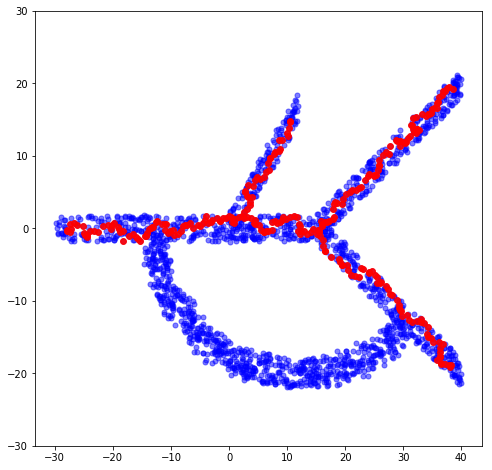

In [281]:
fig = plt.figure( figsize=(8,8))
ax1 = fig.add_subplot(111)
cc = "blue"
ax1.scatter( data[down_ind,0], data[down_ind,1], alpha=0.5, s=25, c=cc)
ax1.scatter( data[out_ids,0], data[out_ids,1], alpha=0.9, s=35, c='r')
ax1.set_ylim(-30,30)

In [283]:
# bin downsampled data points to each node
down_node_dist = pairwise_distances(data[down_ind], data[out_ids])
down_node_dist.shape

(2018, 273)

In [304]:
bin_id = np.argsort( down_node_dist, axis=1)[:,0]
#pd.value_counts( bin_id)

(-30, 30)

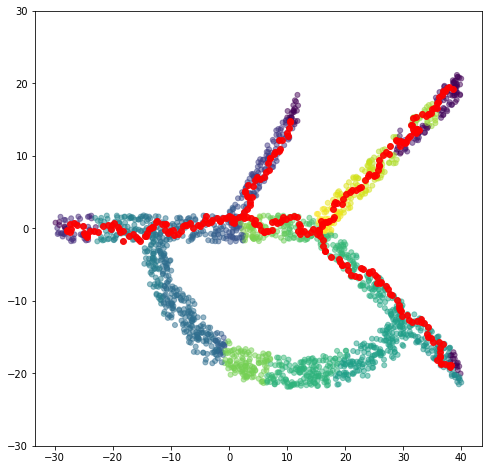

In [305]:
fig = plt.figure( figsize=(8,8))
ax1 = fig.add_subplot(111)
cc = bin_id
ax1.scatter( data[down_ind,0], data[down_ind,1], alpha=0.5, s=25, c=cc)
ax1.scatter( data[out_ids,0], data[out_ids,1], alpha=0.9, s=35, c='r')
ax1.set_ylim(-30,30)